# Train, validate, test

Current learning rate: [0.001]
Epoch 1/200 | Train Loss: 0.1336 | Val Loss: 0.0632
Current learning rate: 0.001
💾 Best model saved.
Epoch 2/200 | Train Loss: 0.0952 | Val Loss: 0.0548
Current learning rate: 0.001
💾 Best model saved.
Epoch 3/200 | Train Loss: 0.0915 | Val Loss: 0.0552
Current learning rate: 0.001
Epoch 4/200 | Train Loss: 0.0902 | Val Loss: 0.0565
Current learning rate: 0.001
Epoch 5/200 | Train Loss: 0.0888 | Val Loss: 0.0557
Current learning rate: 0.001
Epoch 6/200 | Train Loss: 0.0883 | Val Loss: 0.0507
Current learning rate: 0.001
💾 Best model saved.
Epoch 7/200 | Train Loss: 0.0876 | Val Loss: 0.0525
Current learning rate: 0.001
Epoch 8/200 | Train Loss: 0.0871 | Val Loss: 0.0538
Current learning rate: 0.001
Epoch 9/200 | Train Loss: 0.0865 | Val Loss: 0.0532
Current learning rate: 0.001
Epoch 10/200 | Train Loss: 0.0860 | Val Loss: 0.0544
Current learning rate: 0.001
Epoch 11/200 | Train Loss: 0.0857 | Val Loss: 0.0498
Current learning rate: 0.001
💾 Best model sav

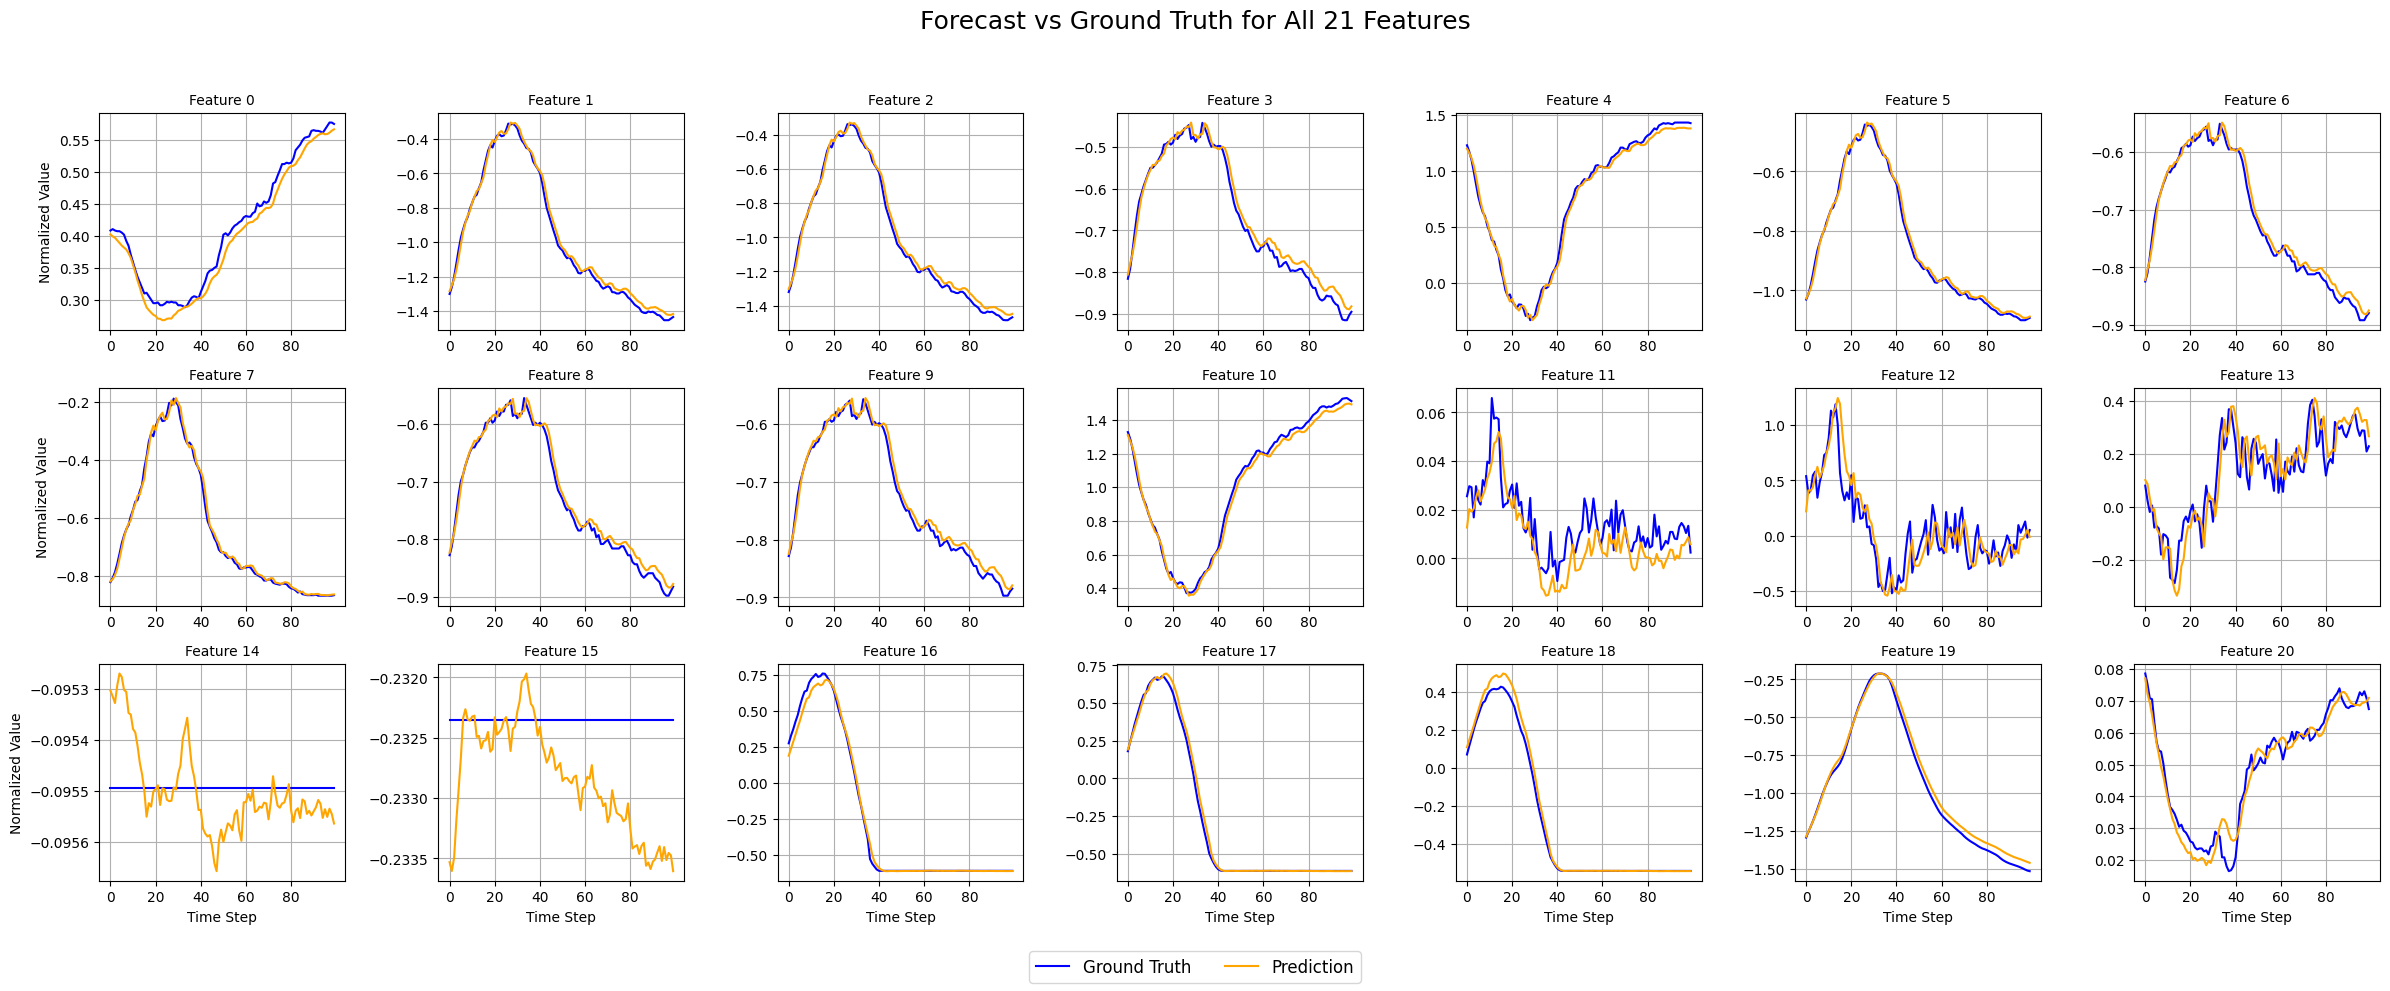

✅ Tuned model saved as lstm_weather_model_tuned.pth


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Load and Prepare Data
# ---------------------------
df = pd.read_csv('Weather.csv')
df['date'] = pd.to_datetime(df['date'])
data = df.drop(columns=['date'])

# Normalize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = np.array(data_scaled, dtype=np.float32)

# ---------------------------
# Create sequences with sliding window
# ---------------------------
def create_sequences(data, input_len=5, output_len=1, stride=1):
    X, y = [], []
    for i in range(0, len(data) - input_len - output_len + 1, stride):
        X.append(data[i:i+input_len])  # Input sequence of length 'input_len'
        y.append(data[i+input_len:i+input_len+output_len])  # Output sequence of length 'output_len'
    return np.array(X), np.array(y)

INPUT_LEN = 5  # Input length (5 data points)
OUTPUT_LEN = 1  # Output length (next data point)

# Create sequences using sliding window
X, y = create_sequences(data_scaled, input_len=INPUT_LEN, output_len=OUTPUT_LEN, stride=1)

# Split data into train, validation, and test sets
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# ---------------------------
# Step 2: Dataset and DataLoader
# ---------------------------
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(WeatherDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(WeatherDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(WeatherDataset(X_test, y_test), batch_size=64)

# ---------------------------
# Step 3: LSTM Model with Bidirectional LSTM and Dropout
# ---------------------------
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_len, output_size, dropout=0.2):
        super(LSTMForecast, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size * 2, output_len * output_size)  # Account for bidirectionality
        self.output_len = output_len
        self.output_size = output_size

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take the last time step output
        out = self.linear(out)
        return out.view(-1, self.output_len, self.output_size)

# ---------------------------
# Step 4: Training + Validation with MAE Loss and L2 Regularization, Early Stopping, and Learning Rate Scheduler
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMForecast(input_size=21, hidden_size=128, num_layers=2,
                     output_len=OUTPUT_LEN, output_size=21, dropout=0.2).to(device)

# Use MAE Loss instead of MSE
criterion = nn.L1Loss()  # Mean Absolute Error (MAE)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # L2 regularization

# Learning Rate Scheduler (reduce lr on plateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
current_lr = scheduler.get_last_lr()
print("Current learning rate:", current_lr)

EPOCHS = 200
patience = 10  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Learning rate scheduler step
    scheduler.step(avg_val_loss)
    print("Current learning rate:", scheduler.optimizer.param_groups[0]['lr'])

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
        print("💾 Best model saved.")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"⚠️ Early stopping triggered. No improvement in validation loss for {patience} epochs.")
            break

# ---------------------------
# Step 5: Test Evaluation
# ---------------------------
model.eval()
test_loss = 0.0
all_preds, all_targets = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        test_loss += loss.item()

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f"\n🧪 Test Loss: {avg_test_loss:.4f}")

# ---------------------------
# Step 6: Plot Predictions vs Ground Truth
# ---------------------------

# Concatenate predictions and targets across batches
preds_arr = np.concatenate(all_preds, axis=0)    # Shape: [num_samples, output_len, num_features]
targets_arr = np.concatenate(all_targets, axis=0)

# Check the shape of the arrays
print(f"Predictions shape: {preds_arr.shape}")
print(f"Targets shape: {targets_arr.shape}")

# Create subplots for all 21 features
num_features = 21

# Create subplots with a size large enough to display all features
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(24, 10))
fig.suptitle(f"Forecast vs Ground Truth for All 21 Features", fontsize=18)

# Loop through each feature (21 total)
for i in range(num_features):
    row = i // 7
    col = i % 7
    ax = axes[row, col]

    # Plot ground truth and predictions for the first 100 samples of the current feature
    ax.plot(np.arange(100), targets_arr[:100, 0, i], label='Ground Truth', color='blue')
    ax.plot(np.arange(100), preds_arr[:100, 0, i], label='Prediction', color='orange')

    ax.set_title(f"Feature {i}", fontsize=10)
    ax.set_xticks(np.arange(0, 100, step=20))  # Adjust the x-ticks for the range of 100
    ax.grid(True)

    if row == 2:
        ax.set_xlabel("Time Step")
    if col == 0:
        ax.set_ylabel("Normalized Value")

# Add a shared legend from the first subplot (consistent across all)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)

# Adjust layout to fit legend and title
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# ---------------------------
# Step 7: Save & Load Model
# ---------------------------
torch.save(model.state_dict(), "lstm_weather_model_tuned.pth")
print("✅ Tuned model saved as lstm_weather_model_tuned.pth")

# To load later:
# model.load_state_dict(torch.load("lstm_weather_model_tuned.pth"))
# model.eval()